**Goal of the project:** To identify the most profitable product categories and regions, analyze sales seasonality, and forecast sales for the next quarter.

In [66]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

In [55]:
# Load dataset (assuming it's in the working directory as 'Superstore.csv')
df = pd.read_csv(r'D:\MERCYBUNDI\OneDrive\Desktop\data science with python\Study Projects\Superstore dataset.csv')

# Quick look at the data
print(df.shape)
print(df.columns)

(10800, 21)
Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')


In [3]:
# Trying to see the top rows and bottom rows, and get the layout of the dataset

print(df.head())
print(df.tail())

  Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0      1  CA-2017-152156   11/8/2017  11/11/2017    Second Class    CG-12520   
1      2  CA-2017-152156   11/8/2017  11/11/2017    Second Class    CG-12520   
2      3  CA-2017-138688   6/12/2017   6/16/2017    Second Class    DV-13045   
3      4  US-2016-108966  10/11/2016  10/18/2016  Standard Class    SO-20335   
4      5  US-2016-108966  10/11/2016  10/18/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0     42420.0   South  FUR

In [56]:
# Overview of the data

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10800 entries, 0 to 10799
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         10800 non-null  object 
 1   Order ID       10800 non-null  object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9983 non-null   float64
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quanti

In [57]:
# Check for missing values

print(df.isnull().sum())

Row ID             0
Order ID           0
Order Date       806
Ship Date        806
Ship Mode        806
Customer ID      806
Customer Name    806
Segment          806
Country          806
City             806
State            806
Postal Code      817
Region           806
Product ID       806
Category         806
Sub-Category     806
Product Name     806
Sales            806
Quantity         806
Discount         806
Profit           806
dtype: int64


In [58]:
# Dropping the null values

df.dropna(inplace=True)

In [59]:
# Check for duplicates

duplicates = df.duplicated().sum()
print("Duplicates:", duplicates)

df = df.drop_duplicates()

Duplicates: 0


In [60]:
# Convert date columns to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Convert PostalCode to string/object
df['Postal Code'] = df['Postal Code'].astype('object')


In [61]:
# Verify cleaning
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9983 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9983 non-null   object        
 1   Order ID       9983 non-null   object        
 2   Order Date     9983 non-null   datetime64[ns]
 3   Ship Date      9983 non-null   datetime64[ns]
 4   Ship Mode      9983 non-null   object        
 5   Customer ID    9983 non-null   object        
 6   Customer Name  9983 non-null   object        
 7   Segment        9983 non-null   object        
 8   Country        9983 non-null   object        
 9   City           9983 non-null   object        
 10  State          9983 non-null   object        
 11  Postal Code    9983 non-null   object        
 12  Region         9983 non-null   object        
 13  Product ID     9983 non-null   object        
 14  Category       9983 non-null   object        
 15  Sub-Category   9983 non-nu

**Identifing the most profitable product categories and regions**

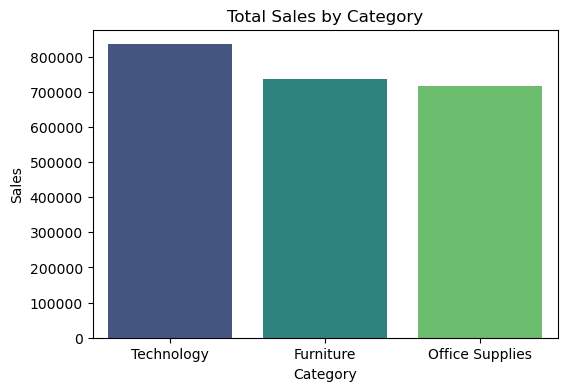

In [62]:
# Sales by Category
category_sales = df.groupby('Category')['Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=category_sales.index, y=category_sales.values, hue=category_sales.index, palette='viridis', legend=False)
                    #here a simple Series has been created where the categories are the index and the sum are the values
plt.title('Total Sales by Category')
plt.ylabel('Sales')
plt.show()

* In a plot, the legend is the little box (usually to the side or top) that explains what the colors, lines, or markers represent.
* You have to specify a **hue**, so Seaborn knows how to apply the color palette (since **palette** is meant to color different groups).
* If you just want to change the colour of a figure,just use **colour** (eg,**color='skyblue'**) in a dataframe that has no groups

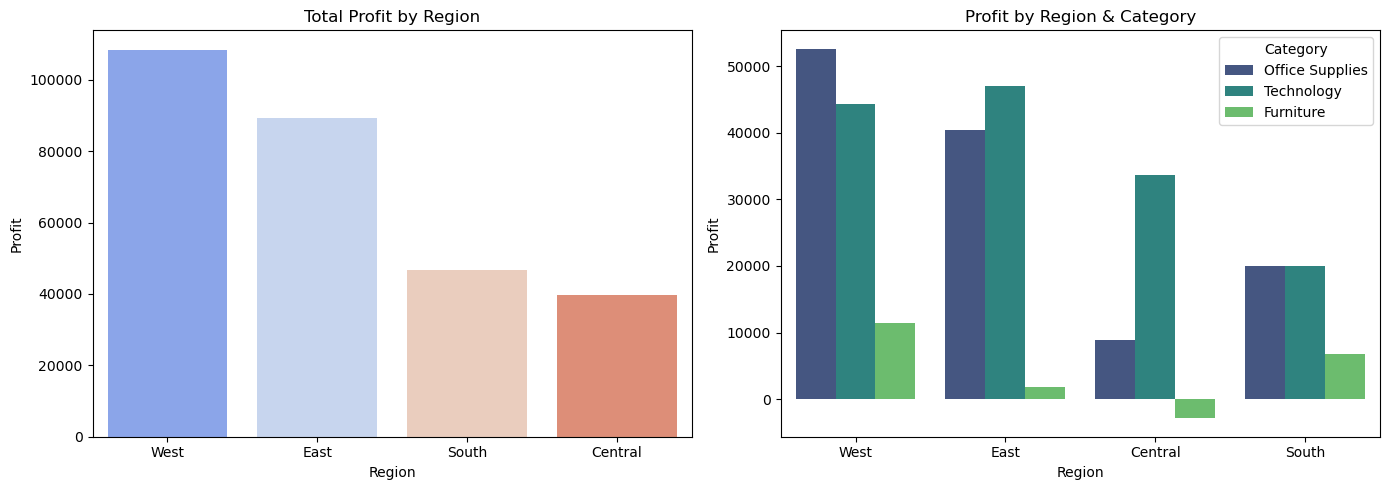

In [63]:
# Profit by Region (overall)
region_profit = df.groupby('Region')['Profit'].sum().sort_values(ascending=False).reset_index()

# Profit by Region & Category (for breakdown)
region_cat_profit = df.groupby(['Region', 'Category'])['Profit'].sum().sort_values(ascending=False).reset_index()

# --- Create figure with 2 subplots ---
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,5))

# 1) Profit by Region
sns.barplot(data=region_profit, x='Region', y='Profit', hue='Region',
            palette='coolwarm', legend=False, ax=ax1)
ax1.set_title('Total Profit by Region')
ax1.set_ylabel('Profit')
ax1.set_xlabel('Region')

# 2) Profit by Region & Category
sns.barplot(data=region_cat_profit, x='Region', y='Profit', hue='Category',
            palette='viridis', ax=ax2)
ax2.set_title('Profit by Region & Category')
ax2.set_ylabel('Profit')
ax2.set_xlabel('Region')
ax2.legend(title='Category')

plt.tight_layout()
plt.show()


**Checking Sales Seasonality**

In [64]:
# Convert to time series
df = df.set_index('Order Date')  # make dates the index
sales_ts = df['Sales'].resample('ME').sum()


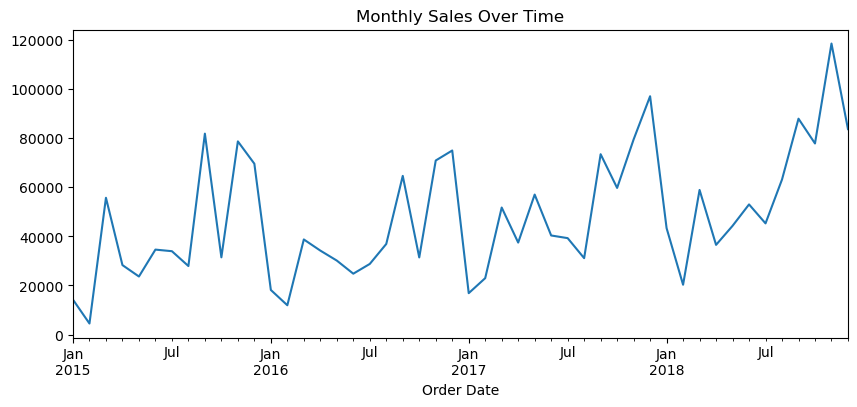

In [65]:
# Visualizng sales over time

sales_ts.plot(figsize=(10,4))
plt.title("Monthly Sales Over Time")
plt.show()

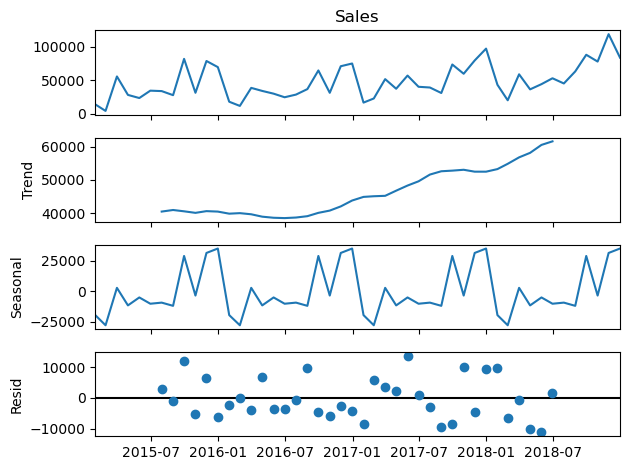

In [67]:
# Decompose the time series

decomp = seasonal_decompose(sales_ts, model='additive', period=12)
decomp.plot()
plt.show()

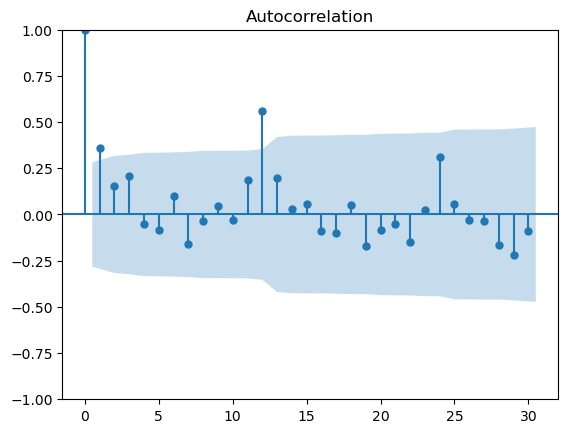

In [70]:
# Check autocorrelation (ACF)

plot_acf(sales_ts, lags = 30)
plt.show()

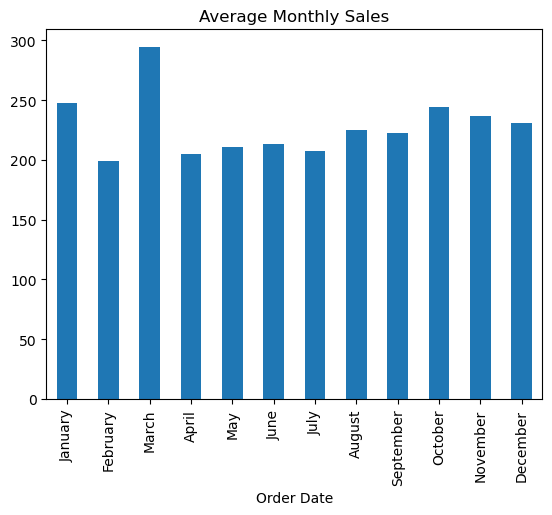

In [77]:
# Seasonal Summary

months_order = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']

sales_monthly = df.groupby(df.index.strftime('%B'))['Sales'].mean().reindex(months_order)
sales_monthly.plot(kind='bar')
plt.title("Average Monthly Sales")
plt.show()

**Rule of Thumb:**
* Use **Pandas** when you just need a quick plot (especially for summaries or EDA).

* Use **Seaborn** when you want more attractive plots or need to handle grouped data (hue, multiple lines).

* Use **Matplotlib** when you need full control (custom ticks, multiple subplots, annotations, etc.).

**Forecast sales for the 3 months**

In [78]:
# Train-test split (last 3 months for testing)
train, test = sales_ts.iloc[:-3], sales_ts.iloc[-3:]
test.head(3)

Order Date
2018-10-31     77776.9232
2018-11-30    118447.8250
2018-12-31     83624.2888
Freq: ME, Name: Sales, dtype: float64

In [79]:
#Fit SARIMA
model = auto_arima(train,             # Your train time series data (monthly sales)
                   seasonal=True,        # Allow seasonal ARIMA (SARIMA)
                   m=12,                 # Season length = 12 (monthly data, so 12 months per year)
                   suppress_warnings=True # Hide warnings about convergence or stationarity
                  )

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   45
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -496.998
Date:                            Tue, 29 Jul 2025   AIC                           1001.996
Time:                                    23:20:15   BIC                           1009.132
Sample:                                01-31-2015   HQIC                          1004.642
                                     - 09-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5563      0.222     -2.504      0.012      -0.992      -0.121
ar.L2         -0.2257      0.213     -1.058      0.290      -0.644       0.192
ar.S.L12       0.6328      0.181      3.489      0.000       0.277       0.988
sigma2      5.087e+08   1.51e-10   3.37e+18      0.000    5.09e+08    5.09e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 4.71
Prob(Q):                              0.65   Prob(JB):                         0.09
Heteroskedasticity (H):               0.40   Skew:                            -0.47
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.25e+33. Standard errors may be unstable.
"""

In [80]:
# Predictions 3 months
predictions = model.predict(n_periods = len(test))
predictions


2018-10-31     75113.483958
2018-11-30     90315.390019
2018-12-31    100850.789693
Freq: ME, dtype: float64

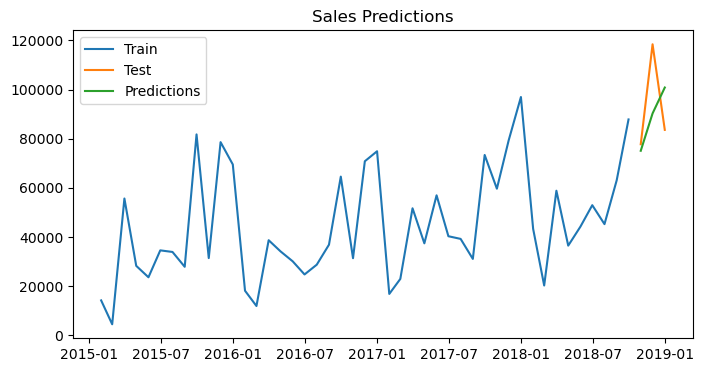

The MAE is 16007.46
The RMSE is 19107.42
The MAPE is 15.93 %


In [81]:
# Plot predictions vs actual
plt.figure(figsize=(8,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.title('Sales Predictions')
plt.show()

# Calculating the MAE, RMSE, and MAPE
mae = mean_absolute_error(test, predictions)
rmse = root_mean_squared_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)

# Print the calculated error metrics
print(f"The MAE is {mae:.2f}")
print(f"The RMSE is {rmse:.2f}")
print(f"The MAPE is {100 * mape:.2f} %")

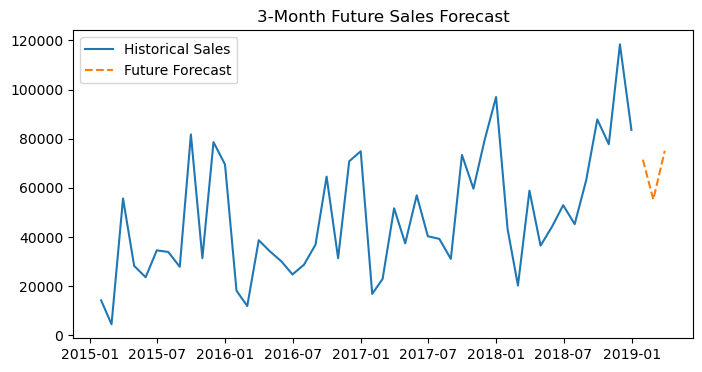

In [82]:
# Plot the future 3 months

# Fit on the full dataset now
model = auto_arima(sales_ts, seasonal=True, m=12)

# Forecast 3 months beyond the last date
future_forecast = model.predict(n_periods=3)

# Plot the whole history + forecast
plt.figure(figsize=(8,4))
plt.plot(sales_ts.index, sales_ts, label='Historical Sales')
plt.plot(future_forecast.index, future_forecast, label='Future Forecast', linestyle='--')
plt.legend()
plt.title('3-Month Future Sales Forecast')
plt.show()